In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import math
import plotly.graph_objects as go

In [82]:
import os
import sys

nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [83]:
from core.time_series_clustering import KmeansClustering
from core.data_preparation import DataPreparation


In [84]:
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

Load and Prepare data to input to LSTM model

In [85]:
filepath = "../Data/MRF_clean.csv"
data = pd.read_csv(filepath)
data = data.sort_values('date')
data.head()

,date,close
0,2005-01-03,2542.550049
1,2005-01-04,2550.050049
2,2005-01-05,2577.300049
3,2005-01-06,2512.550049
4,2005-01-07,2498.949951


In [86]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='closing price'))


In [88]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [89]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (3351, 20, 1)
y_train.shape =  (3351, 1)
x_test.shape =  (823, 20, 1)
y_test.shape =  (823, 1)


In [90]:
num_clusters = 5

In [91]:
kmeans = KmeansClustering(num_clusters)
kmeans.compute_clusters(x_train)

DBA k-means


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


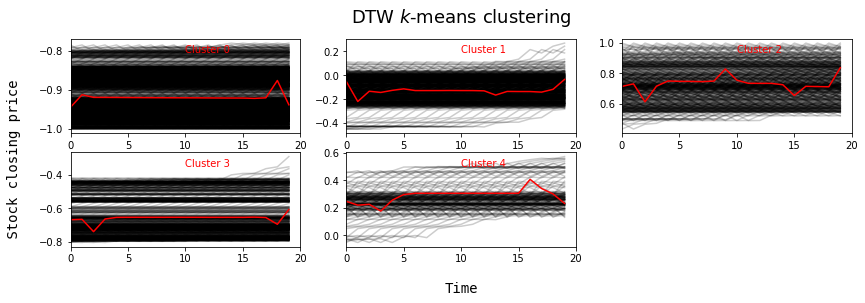

In [92]:
kmeans.visualize_clustering_results()

In [93]:
y_train = y_train_lstm.flatten().numpy()

In [94]:
type(y_train)

numpy.ndarray

In [95]:
train_errors = pd.read_csv('MRF_ErrorDistribution.csv', usecols=[2])
train_errors.head()

,diff
0,216.765620
1,218.117920
2,121.016110
3,50.843018
4,34.142090


In [96]:
clusters = []
for i in range(num_clusters):

    clusters.append(scaler.inverse_transform(kmeans.cluster_centers_[i].flatten().reshape(-1,1)))

In [97]:
kmeans.cluster_centers_[2].flatten()

array([0.71386082, 0.73042381, 0.61190694, 0.71518016, 0.74936105,
       0.74715487, 0.74665733, 0.74543323, 0.74883624, 0.82926145,
       0.75481896, 0.73416054, 0.73379737, 0.73382813, 0.72464114,
       0.65328073, 0.71420514, 0.71271557, 0.71127266, 0.83727514])

In [98]:
train_preds = kmeans.predict(x_train)

In [99]:
model = torch.load('lstm_mrf.pt')
model.eval()

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [100]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

Test Score: 0.02 MAPE
R-squared value is 0.9425788046685755
RMSE:  2456.9698817852855


#### Predict the cluster for forecast data

In [101]:
#prepare forecasts for clustering

preds = y_test_pred.detach().numpy()
preds = preds[:,0]
loop = len(preds) - window_size + 1 
forecasts = []

for i in range(loop):        
    window = preds[i:i+window_size]
    forecasts.append(window)  

forecasts = np.asarray(forecasts).reshape(-1, window_size, 1)

In [102]:
#prepare test gt for performance comparison

gt = y_test_lstm.detach().numpy()
gt = gt[:,0]
loop = len(gt) - window_size + 1 
test_gt = []

for i in range(loop):        
    window = gt[i:i+window_size]
    test_gt.append(window)  

test_gt = np.asarray(test_gt).reshape(-1, window_size, 1)

In [103]:
test_gt.shape, forecasts.shape

((804, 20, 1), (804, 20, 1))

In [104]:
res = kmeans.predict(forecasts)

In [105]:
np.where(res == 6)

(array([], dtype=int64),)

#### Find distances between each cluster centroid and a reference time series

In [106]:
ref_ts = np.zeros(20)

In [107]:
ref_ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [108]:
clusters[0].flatten()

array([3745.1278258 , 5006.45425597, 4738.27266712, 4735.15105902,
       4730.47532768, 4721.10105444, 4714.90928357, 4706.98793468,
       4701.19038595, 4696.57059864, 4693.48502076, 4689.72636968,
       4682.24723158, 4676.1210781 , 4671.07583403, 4668.34856252,
       4635.57159608, 4690.9282461 , 6447.4181903 , 3987.3439194 ])

In [109]:
clusters_wd_dist = []
for i in range(num_clusters):

    wd = kmeans.compute_wasserstein_distance(ref_ts, clusters[i].flatten())

    clusters_wd_dist.append(wd)


In [110]:
clusters_wd_dist

[4644.877125355052,
 36104.03120670783,
 70230.2463705324,
 14919.59130009756,
 52513.9438562388]

In [111]:
f380 = scaler.inverse_transform(forecasts[380].flatten().reshape(-1,1))

In [112]:
kmeans._get_statistical_dist_measures(f380.flatten(), np.zeros(20))

{'Anderson_Darling_dist': 3.708417172625208,
 'CVM_dist': 10.450000000000003,
 'DTS_dist': 18774.865851240233,
 'Kolmogorov_Smirnov_dist': 1.0000000000000002,
 'Kuiper_dist': 1.0000000000000002,
 'Wasserstein distance': 59288.01210937501}

In [113]:
len(forecasts)

804

In [114]:
# np.random.seed(4)

## Fix these values of indices to reacreate/edit plots

indices = [580, 731, 671, 287, 482, 764, 444, 646,  99, 591, 177, 546, 258,
                  757, 611]

#indices = np.random.choice(range(0, len(forecasts), 1), 15)
#indices

In [115]:
# t = [130, 184, 244, 225, 160, 235, 245, 176, 175, 30, 264, 256, 278, 300, 305, 380, 406, 420, 450, 467]

t = indices
df = kmeans.ecdf_between_cluster_and_data(t, scaler, forecasts, res, clusters_wd_dist)

In [116]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,580,1.075029,2,70230.246371,7.151244,19.95,4528.922135,1.00,1.00,13589.633757
1,731,0.942240,2,70230.246371,7.151244,19.95,2876.006539,1.00,1.00,8298.743913
2,671,0.960652,2,70230.246371,7.151244,19.95,3091.573752,1.00,1.00,9050.532976
3,287,0.576439,2,70230.246371,7.087958,19.75,2170.656602,0.95,0.95,6170.513167
4,482,0.458810,4,52513.943856,5.170010,14.10,2382.479966,1.00,1.00,6743.206833
5,764,0.899660,2,70230.246371,7.151244,19.95,2325.848093,1.00,1.00,6626.895866
6,444,0.551602,2,70230.246371,7.119621,19.85,2475.597134,0.95,0.95,7155.678206
7,646,0.956822,2,70230.246371,7.151244,19.95,3070.855149,1.00,1.00,8898.575945
8,99,0.395921,4,52513.943856,4.876613,13.20,1569.258656,0.95,0.95,4252.623630
9,591,1.059778,2,70230.246371,7.151244,19.95,4326.296506,1.00,1.00,12974.377116


In [117]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance
0,580,1.075029,2,70230.246371,7.151244,19.95,4528.922135,1.00,1.00,13589.633757
1,731,0.942240,2,70230.246371,7.151244,19.95,2876.006539,1.00,1.00,8298.743913
2,671,0.960652,2,70230.246371,7.151244,19.95,3091.573752,1.00,1.00,9050.532976
3,287,0.576439,2,70230.246371,7.087958,19.75,2170.656602,0.95,0.95,6170.513167
4,482,0.458810,4,52513.943856,5.170010,14.10,2382.479966,1.00,1.00,6743.206833
5,764,0.899660,2,70230.246371,7.151244,19.95,2325.848093,1.00,1.00,6626.895866
6,444,0.551602,2,70230.246371,7.119621,19.85,2475.597134,0.95,0.95,7155.678206
7,646,0.956822,2,70230.246371,7.151244,19.95,3070.855149,1.00,1.00,8898.575945
8,99,0.395921,4,52513.943856,4.876613,13.20,1569.258656,0.95,0.95,4252.623630
9,591,1.059778,2,70230.246371,7.151244,19.95,4326.296506,1.00,1.00,12974.377116


In [118]:
df['WD ratio'] = df['Wasserstein distance'] / df['WD origin']

In [119]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio
0,580,1.075029,2,70230.246371,7.151244,19.95,4528.922135,1.00,1.00,13589.633757,0.193501
1,731,0.942240,2,70230.246371,7.151244,19.95,2876.006539,1.00,1.00,8298.743913,0.118165
2,671,0.960652,2,70230.246371,7.151244,19.95,3091.573752,1.00,1.00,9050.532976,0.128869
3,287,0.576439,2,70230.246371,7.087958,19.75,2170.656602,0.95,0.95,6170.513167,0.087861
4,482,0.458810,4,52513.943856,5.170010,14.10,2382.479966,1.00,1.00,6743.206833,0.128408
5,764,0.899660,2,70230.246371,7.151244,19.95,2325.848093,1.00,1.00,6626.895866,0.094360
6,444,0.551602,2,70230.246371,7.119621,19.85,2475.597134,0.95,0.95,7155.678206,0.101889
7,646,0.956822,2,70230.246371,7.151244,19.95,3070.855149,1.00,1.00,8898.575945,0.126706
8,99,0.395921,4,52513.943856,4.876613,13.20,1569.258656,0.95,0.95,4252.623630,0.080981
9,591,1.059778,2,70230.246371,7.151244,19.95,4326.296506,1.00,1.00,12974.377116,0.184741


In [120]:
rmse_errors = []
mape_errors = []
r2score = []
for i in t:

    forecast = scaler.inverse_transform(forecasts[i])
    gt = scaler.inverse_transform(test_gt[i])
    rmse = math.sqrt(mean_squared_error(gt, forecast))
    rmse_errors.append(rmse)

    mape = mean_absolute_percentage_error(gt, forecast)
    mape_errors.append(mape*100)

    r2 = r2_score(gt, forecast)
    r2score.append(r2)

In [121]:
df = df.assign(**{'RMSE': rmse_errors, 'MAPE':mape_errors, 'R2-score': r2score})

In [122]:
df 

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score
0,580,1.075029,2,70230.246371,7.151244,19.95,4528.922135,1.00,1.00,13589.633757,0.193501,6263.202056,6.368051,-5.290872
1,731,0.942240,2,70230.246371,7.151244,19.95,2876.006539,1.00,1.00,8298.743913,0.118165,3514.223385,3.096213,-0.731989
2,671,0.960652,2,70230.246371,7.151244,19.95,3091.573752,1.00,1.00,9050.532976,0.128869,2095.575458,2.263159,-4.183759
3,287,0.576439,2,70230.246371,7.087958,19.75,2170.656602,0.95,0.95,6170.513167,0.087861,1144.084514,1.624389,0.529888
4,482,0.458810,4,52513.943856,5.170010,14.10,2382.479966,1.00,1.00,6743.206833,0.128408,1457.799369,2.145389,-0.354405
5,764,0.899660,2,70230.246371,7.151244,19.95,2325.848093,1.00,1.00,6626.895866,0.094360,1279.413489,1.459658,0.576017
6,444,0.551602,2,70230.246371,7.119621,19.85,2475.597134,0.95,0.95,7155.678206,0.101889,2017.472986,2.992036,-2.761673
7,646,0.956822,2,70230.246371,7.151244,19.95,3070.855149,1.00,1.00,8898.575945,0.126706,3440.814293,3.850972,-4.509628
8,99,0.395921,4,52513.943856,4.876613,13.20,1569.258656,0.95,0.95,4252.623630,0.080981,942.252885,1.383364,-0.238008
9,591,1.059778,2,70230.246371,7.151244,19.95,4326.296506,1.00,1.00,12974.377116,0.184741,4501.179179,4.640923,-4.321066


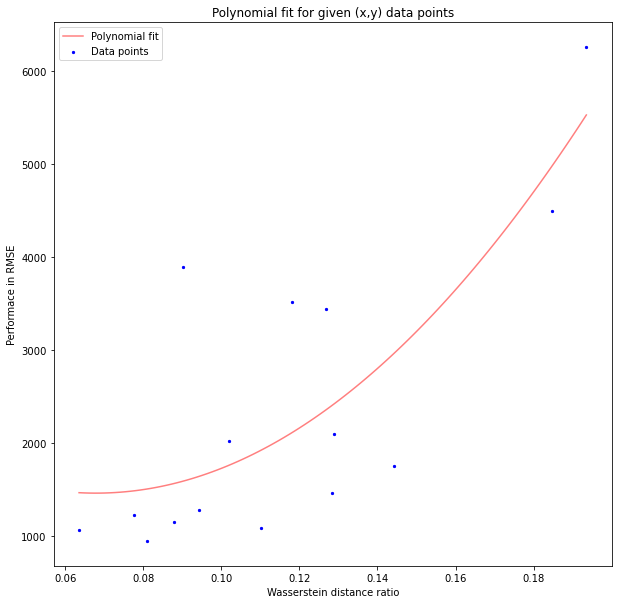

In [123]:
fit_polynomial_curve_to_data_and_visualize(df['WD ratio'].values, rmse_errors, 2, xlabel='Wasserstein distance ratio', ylabel='Performace in RMSE')

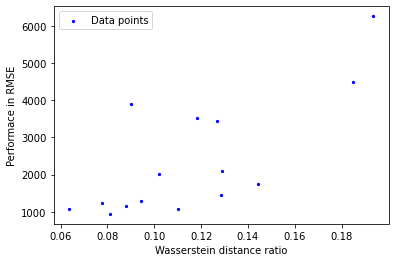

In [124]:
#Plotting
fig1 = plt.figure()
ax1 = fig1.subplots()
ax1.scatter(df['WD ratio'], rmse_errors, s = 5, color = 'b', label = 'Data points')
ax1.set_xlabel('Wasserstein distance ratio')
ax1.set_ylabel('Performace in RMSE')
ax1.legend()
plt.show()

#### Find MSE of each data point using CONFINE method

In [125]:
for i in range(num_clusters):
    print(f"cluster {i}- {len(kmeans.data[kmeans.data_preds == i])}")

cluster 0- 1765
cluster 1- 506
cluster 2- 335
cluster 3- 609
cluster 4- 136


In [126]:
num_neighbors = 19

In [127]:
y_train = y_train_lstm.flatten().numpy()

##### Get indices of the training points that have been assigned to respective cluster

In [128]:
cluster0 = (np.where(kmeans.labels_ == 0))
cluster1 = (np.where(kmeans.labels_ == 1))
cluster2 = (np.where(kmeans.labels_ == 2))
cluster3 = (np.where(kmeans.labels_ == 3))
cluster4 = (np.where(kmeans.labels_ == 4))

##### Get the difference between train preds and train gt values 

In [129]:
train_diff_df = pd.read_csv('MRF_ErrorDistribution.csv', usecols=[2])
train_diff_df.head()

,diff
0,216.765620
1,218.117920
2,121.016110
3,50.843018
4,34.142090


##### Get training points (members) of each cluster 

In [130]:
training_diff = train_diff_df['diff']
training_diff = training_diff.values

In [131]:
type(training_diff)

numpy.ndarray

In [132]:
cluster0_errors = training_diff[cluster0[0]]
cluster1_errors = training_diff[cluster1[0]]
cluster2_errors = training_diff[cluster2[0]]
cluster3_errors = training_diff[cluster3[0]]
cluster4_errors = training_diff[cluster4[0]]


In [133]:
np.random.seed(21)
cluster2_neighbors = np.random.choice(cluster2_errors, num_neighbors, replace=False)
cluster4_neighbors = np.random.choice(cluster4_errors, num_neighbors, replace=False)

In [134]:
cluster2_neighbors

array([  78.77344  , 1387.2109   ,    9.1015625,  712.5      ,
        948.3828   , 1238.625    ,  977.5547   ,  873.0469   ,
        678.35156  , 3610.4844   , 3967.3828   , 1633.6367   ,
       2358.039    , 2777.6484   , 1171.2422   ,  864.22656  ,
       1278.5938   ,  623.0781   , 2282.9531   ])

In [135]:
squared_error_2 = [n ** 2 for n in cluster2_neighbors]
squared_error_2 = np.array(squared_error_2)

In [136]:
squared_error_4 = [n ** 2 for n in cluster4_neighbors]
squared_error_4 = np.array(squared_error_4)

In [137]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_2 = scaler.fit_transform(squared_error_2.reshape(-1, 1))

In [138]:
scaler = MinMaxScaler(feature_range=(0, 1))
se_norm_4 = scaler.fit_transform(squared_error_4.reshape(-1, 1))

In [139]:
se_norm_2 = np.around(se_norm_2, 4)

In [140]:
se_norm_4 = np.around(se_norm_4, 4)

In [141]:
mse_2 = np.mean(se_norm_2)

In [142]:
mse_2 = np.round(mse_2, 4)
mse_2

0.2044

In [143]:
mse_4 = np.mean(se_norm_4)

In [144]:
mse_4 = np.round(mse_4, 4)
mse_4

0.1421

In [145]:
confine_mse = []

In [146]:
for i in df['Assigned cluster']:

    if i==2:
        confine_mse.append(mse_2) 
    elif i==4:
        confine_mse.append(mse_4)    


# confine_mse = [0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.2606, 0.3188, 0.3188, 0.3188, 0.3188,
#                 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188, 0.3188]

In [147]:
len(confine_mse)

15

In [148]:
df['mse'] = confine_mse

In [149]:
df

,Test point,Test point mean,Assigned cluster,WD origin,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein distance,WD ratio,RMSE,MAPE,R2-score,mse
0,580,1.075029,2,70230.246371,7.151244,19.95,4528.922135,1.00,1.00,13589.633757,0.193501,6263.202056,6.368051,-5.290872,0.2044
1,731,0.942240,2,70230.246371,7.151244,19.95,2876.006539,1.00,1.00,8298.743913,0.118165,3514.223385,3.096213,-0.731989,0.2044
2,671,0.960652,2,70230.246371,7.151244,19.95,3091.573752,1.00,1.00,9050.532976,0.128869,2095.575458,2.263159,-4.183759,0.2044
3,287,0.576439,2,70230.246371,7.087958,19.75,2170.656602,0.95,0.95,6170.513167,0.087861,1144.084514,1.624389,0.529888,0.2044
4,482,0.458810,4,52513.943856,5.170010,14.10,2382.479966,1.00,1.00,6743.206833,0.128408,1457.799369,2.145389,-0.354405,0.1421
5,764,0.899660,2,70230.246371,7.151244,19.95,2325.848093,1.00,1.00,6626.895866,0.094360,1279.413489,1.459658,0.576017,0.2044
6,444,0.551602,2,70230.246371,7.119621,19.85,2475.597134,0.95,0.95,7155.678206,0.101889,2017.472986,2.992036,-2.761673,0.2044
7,646,0.956822,2,70230.246371,7.151244,19.95,3070.855149,1.00,1.00,8898.575945,0.126706,3440.814293,3.850972,-4.509628,0.2044
8,99,0.395921,4,52513.943856,4.876613,13.20,1569.258656,0.95,0.95,4252.623630,0.080981,942.252885,1.383364,-0.238008,0.1421
9,591,1.059778,2,70230.246371,7.151244,19.95,4326.296506,1.00,1.00,12974.377116,0.184741,4501.179179,4.640923,-4.321066,0.2044


In [150]:
df['staDRE'] = (2 - df['mse'] - df['WD ratio'] ) / 2

In [151]:
df_RE = df[['Test point', 'Assigned cluster', 'RMSE', 'MAPE', 'R2-score', 'WD origin', 'Wasserstein distance', 'WD ratio', 'mse', 'staDRE']]

In [152]:
df_RE

,Test point,Assigned cluster,RMSE,MAPE,R2-score,WD origin,Wasserstein distance,WD ratio,mse,staDRE
0,580,2,6263.202056,6.368051,-5.290872,70230.246371,13589.633757,0.193501,0.2044,0.801049
1,731,2,3514.223385,3.096213,-0.731989,70230.246371,8298.743913,0.118165,0.2044,0.838718
2,671,2,2095.575458,2.263159,-4.183759,70230.246371,9050.532976,0.128869,0.2044,0.833365
3,287,2,1144.084514,1.624389,0.529888,70230.246371,6170.513167,0.087861,0.2044,0.853869
4,482,4,1457.799369,2.145389,-0.354405,52513.943856,6743.206833,0.128408,0.1421,0.864746
5,764,2,1279.413489,1.459658,0.576017,70230.246371,6626.895866,0.094360,0.2044,0.850620
6,444,2,2017.472986,2.992036,-2.761673,70230.246371,7155.678206,0.101889,0.2044,0.846856
7,646,2,3440.814293,3.850972,-4.509628,70230.246371,8898.575945,0.126706,0.2044,0.834447
8,99,4,942.252885,1.383364,-0.238008,52513.943856,4252.623630,0.080981,0.1421,0.888460
9,591,2,4501.179179,4.640923,-4.321066,70230.246371,12974.377116,0.184741,0.2044,0.805430


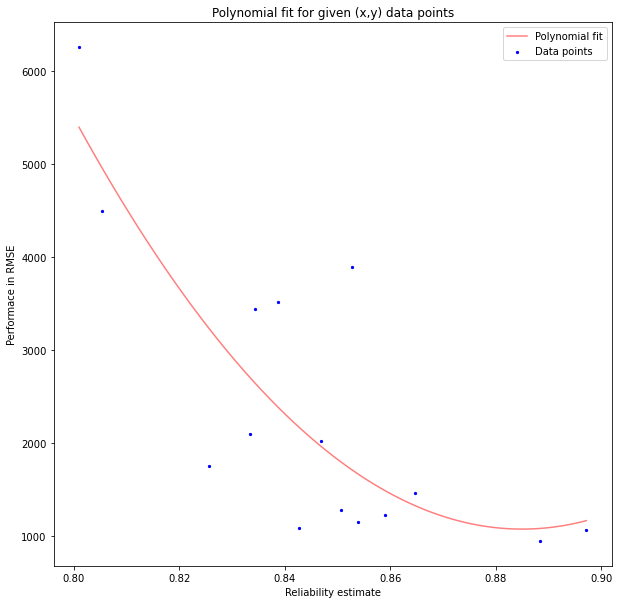

In [153]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['RMSE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in RMSE')

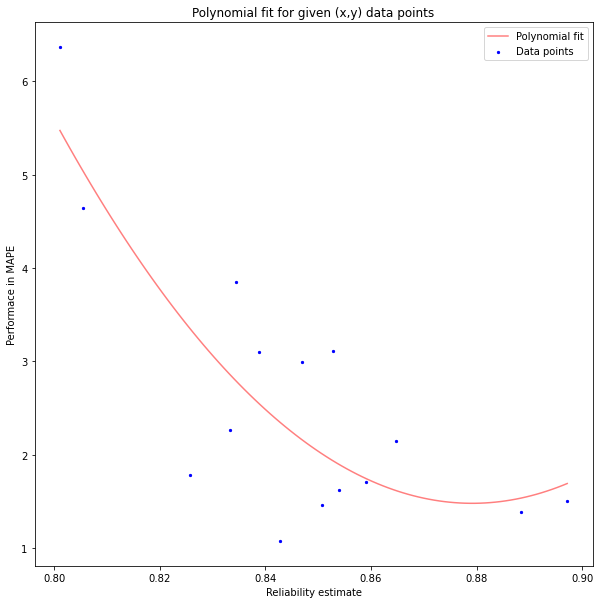

In [154]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['MAPE'].values, 2, xlabel='Reliability estimate', ylabel='Performace in MAPE')

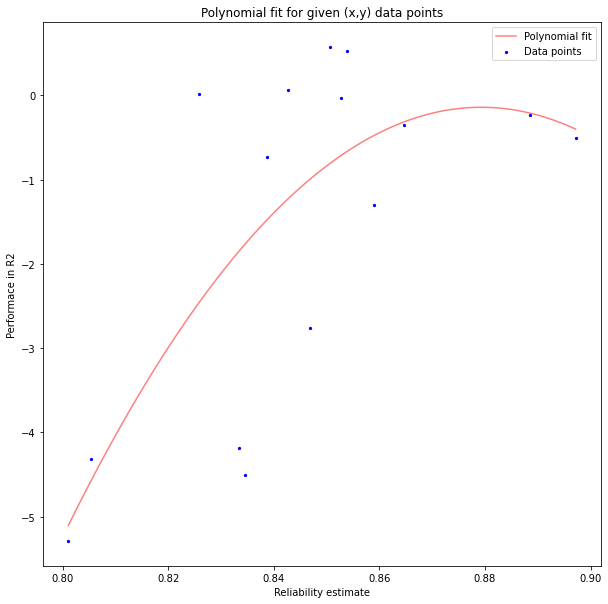

In [155]:
fit_polynomial_curve_to_data_and_visualize(df['staDRE'].values, df['R2-score'].values, 2, xlabel='Reliability estimate', ylabel='Performace in R2')

In [156]:
df_RE.to_csv('MRF_stadre_new.csv', index=False)

In [157]:
scaler = MinMaxScaler()

In [158]:
x = np.array(df_RE['staDRE'].values)
y = np.array(df_RE['RMSE'].values)
# ya = np.array(airtel['MAPE'].values)
# ya = np.array(airtel['R2-score'].values)

z = np.polyfit(x, y, 2)

fit = np.poly1d(z)

x_min = x.min()
x_max = x.max()

xp = np.linspace(x_min, x_max, 100)
yp = fit(xp)

In [159]:
fit

poly1d([  613987.84601908, -1086751.99558114,   481956.19801553])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


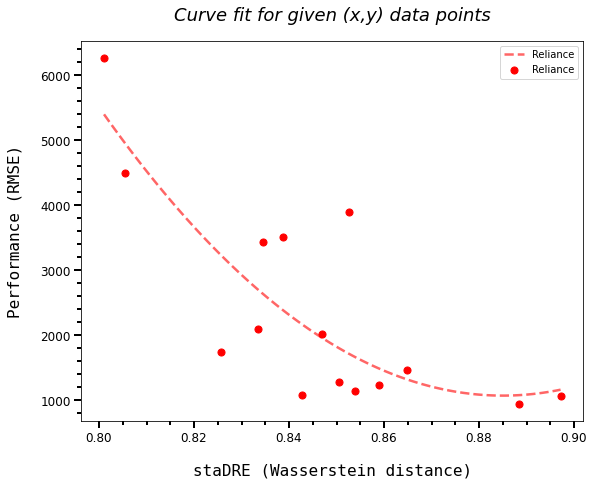

In [160]:
#Plotting RMSE-staDRE
fig1 = plt.figure(figsize=(9,7))
ax1 = fig1.subplots()
ax1.plot(xp, yp, 'r', linestyle='dashed', linewidth=2.5, alpha = 0.6, label = 'Reliance')
ax1.scatter(x, y, 50, 'r', "o", label = 'Reliance')
ax1.set_xlabel('staDRE (Wasserstein distance)', fontsize=16, family='monospace')
plt.xticks(fontsize=12)
ax1.tick_params(which='both', width=2, length=7)
ax1.tick_params(which='minor', length=4)
ax1.xaxis.labelpad = 18
ax1.set_ylabel('Performance (RMSE)', fontsize=16, family='monospace')
plt.yticks(fontsize=12)
ax1.yaxis.labelpad = 18
ax1.set_title('Curve fit for given (x,y) data points', fontsize=18, style='italic', pad=20)
plt.minorticks_on()
ax1.legend(loc='best')

plt.savefig('RMSE_vs._staDRE.eps', dpi=500)
plt.savefig('RMSE_vs._staDRE.jpg', dpi=500)
plt.savefig('RMSE_vs._staDRE.svg', dpi=500)
plt.show()

